# Fine-Tune a Generative AI Model for Dialogue Summarization

The dialogue summary use case notebook, focuses on in-context learning while this notebook looks at modifying the model weights, specific for the summarization task in this notebook and to the loaded dataset.

This notebook utilizes the [FLAN-T5](https://huggingface.co/docs/transformers/model_doc/flan-t5) model, known for its high-quality instruction-tuned capabilities and ability to summarize text without additional modifications. To enhance the model's performance, a full fine-tuning approach is implemented, and the results are evaluated using ROUGE metrics. Subsequently, the notebook investigates Parameter-Efficient Fine-Tuning (PEFT) techniques to fine-tune the model with a reduced number of parameters. The performance of the PEFT model is then evaluated and compared to the fully fine-tuned model, demonstrating that PEFT's advantages in terms of efficiency often outweigh the potential for slightly lower performance metrics. 

The goal of this notebook is to get to the point where one simple call into our model can give us a decent summary without having to pass in the one shot and few shot examples.

## 1 - Install and Import Required Dependencies, Dataset and LLM

### 1.1 - Install and Import Required Dependencies
Leverage the following libraries:
- PyTorch framework
- Torchdata for PyTorch data loading
- Evaluate library to calculate rouge score
- Parameter efficient fine-tuning with loralib and peft


In [54]:
%pip install --upgrade pip
%pip install --disable-pip-version-check \
    torch==2.5.1 \
    torchdata==0.10.1 --quiet

%pip install \
    transformers==4.47.1 \
    datasets==3.2.0 \
    evaluate==0.4.0 \
    rouge_score==0.1.2 \
    loralib==0.1.1 \
    peft==0.3.0 --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import the necessary libraries.

Note: AutoModelForSeq2SeqLM enables access to FLAN-T5. AutoModelForSeq2SeqLM can be used to load any seq2seq (or encoder-decoder) model that has a language modeling (LM) head on top. These include BART, PEGASUS, T5, etc. Full list of supported models in the docs available here: [Auto Classes](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForSeq2SeqLM).

TrainingArguments and Trainer are classes that help simplify the LLM training / fine-tuning.

In [55]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
import torch
import time
import evaluate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 1.2 - Load Dataset and LLM

This notebook experiments with the [DialogSum](https://huggingface.co/datasets/knkarthick/dialogsum) Hugging Face dataset. It contains 10,000+ dialogues with the corresponding manually labeled summaries and topics. 

In [56]:
huggingface_dataset_name = "knkarthick/dialogsum"

dataset = load_dataset(huggingface_dataset_name)

dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})

Load the pre-trained [FLAN-T5 model](https://huggingface.co/docs/transformers/model_doc/flan-t5) and its tokenizer directly from HuggingFace. Notice that this notebook will be using the [small version](https://huggingface.co/google/flan-t5-base) of FLAN-T5. Setting `torch_dtype=torch.bfloat16` specifies the memory type to be used by this model.

```original_model``` will be used as a baseline for comparison for the other fine-tuning strategies. 

In [57]:
model_name='google/flan-t5-base'

original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)

The following convenience function pulls out the number of model parameters and find out how many of them are trainable.

In [58]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params:,}\nall model parameters: {all_model_params:,}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(original_model))

trainable model parameters: 247,577,856
all model parameters: 247,577,856
percentage of trainable model parameters: 100.00%


### 1.3 - Test the Model with Zero Shot Inferencing

Test the model with the zero shot inferencing. The model struggles to summarize the dialogue compared to the baseline summary, but it does pull out some important information from the text which indicates the model can be fine-tuned to the task at hand.

In [59]:
index = 200

dialogue = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

{dialogue}

Summary:
"""

inputs = tokenizer(prompt, return_tensors='pt')
output = tokenizer.decode(
    original_model.generate(
        inputs["input_ids"], 
        max_new_tokens=200,
    )[0], 
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Summarize the following conversation.

#Person1#: Have you considered upgrading your system?
#Person2#: Yes, but I'm not sure what exactly I would need.
#Person1#: You could consider adding a painting program to your software. It would allow you to make up your own flyers and banners for advertising.
#Person2#: That would be a definite bonus.
#Person1#: You might also want to upgrade your hardware because it is pretty outdated now.
#Person2#: How can we do that?
#Person1#: You'd probably need a faster processor, to begin with. And you also need a more powerful hard disc, more memory and a faster modem. Do you have a CD-ROM drive?
#Person2#: No.
#Person1#: Then you might want to add a CD-ROM drive too, because most new software programs are coming out on Cds.
#Person2#: That sounds great. Thanks.

Summary:

-------------------------------------------------------------------

## 2 - Perform Full Fine-Tuning

### 2.1 - Preprocess the Dialog-Summary Dataset

The following convenience function converts the dialog-summary (prompt-response) pairs into explicit instructions for the LLM. It will tokenize and wrap the dataset into a prompt. It will prepend an instruction to the start of the dialog with `Summarize the following conversation` and to the start of the summary with `Summary` as follows:

Training prompt (dialogue):
```
Summarize the following conversation.

    Chris: This is his part of the conversation.
    Antje: This is her part of the conversation.
    
Summary: 
```

Training response (summary):
```
Both Chris and Antje participated in the conversation.
```

Then preprocess the prompt-response dataset into tokens and pull out their `input_ids` (1 per token).

This function will be used to iterate through all elements in the dataset to convert them into prompts with instruction (fine-tuning with instruction prompts).

In [60]:
def tokenize_function(example):
    start_prompt = 'Summarize the following conversation.\n\n'
    end_prompt = '\n\nSummary: '
    prompt = [start_prompt + dialogue + end_prompt for dialogue in example["dialogue"]]
    example['input_ids'] = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt").input_ids
    example['labels'] = tokenizer(example["summary"], padding="max_length", truncation=True, return_tensors="pt").input_ids
    
    return example

# The dataset actually contains 3 diff splits: train, validation, test.
# The tokenize_function code is handling all data across all splits in batches.
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['id', 'topic', 'dialogue', 'summary',])

Map: 100%|██████████| 1500/1500 [00:00<00:00, 2351.58 examples/s]


To save some time in the lab, subsample the dataset:

In [61]:
tokenized_datasets = tokenized_datasets.filter(lambda example, index: index % 100 == 0, with_indices=True)

Filter:   0%|          | 0/1500 [00:00<?, ? examples/s]

Filter: 100%|██████████| 1500/1500 [00:00<00:00, 2236.17 examples/s]


Check the shapes of all three parts of the dataset:

In [62]:
print(f"Shapes of the datasets:")
print(f"Training: {tokenized_datasets['train'].shape}")
print(f"Validation: {tokenized_datasets['validation'].shape}")
print(f"Test: {tokenized_datasets['test'].shape}")

print(tokenized_datasets)

Shapes of the datasets:
Training: (125, 2)
Validation: (5, 2)
Test: (15, 2)
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 125
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 5
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 15
    })
})


The output dataset is ready for fine-tuning.

### 2.2 - Fine-Tune the Model with the Preprocessed Dataset

This section utilizes the built-in Hugging Face `Trainer` class (see the documentation [here](https://huggingface.co/docs/transformers/main_classes/trainer)). Pass the preprocessed dataset with reference to the original model.

max_steps and num_train_epochs are kept at a minimum to reduce resource consumption. 

In [63]:
output_dir = f'./dialogue-summary-training-{str(int(time.time()))}'

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=1e-5,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_steps=1,
    max_steps=1
)

trainer = Trainer(
    model=original_model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation']
)

Start training process.

In [64]:
trainer.train()

100%|██████████| 1/1 [01:07<00:00, 67.92s/it]

{'loss': 47.5, 'grad_norm': 414.0, 'learning_rate': 0.0, 'epoch': 0.06}


100%|██████████| 1/1 [01:09<00:00, 69.17s/it]

{'train_runtime': 69.1774, 'train_samples_per_second': 0.116, 'train_steps_per_second': 0.014, 'train_loss': 47.5, 'epoch': 0.06}


TrainOutput(global_step=1, training_loss=47.5, metrics={'train_runtime': 69.1774, 'train_samples_per_second': 0.116, 'train_steps_per_second': 0.014, 'total_flos': 5478058819584.0, 'train_loss': 47.5, 'epoch': 0.0625})

Training a fully fine-tuned version of the model would take a few hours on a GPU. To save time, download a checkpoint of the fully fine-tuned model to use in the rest of this notebook. This fully fine-tuned model will also be referred to as the **instruct model** in this lab.

In [65]:
instruct_model_name="truocpham/flan-dialogue-summary-checkpoint"

instruct_model = AutoModelForSeq2SeqLM.from_pretrained( instruct_model_name, torch_dtype=torch.bfloat16)

### 2.3 - Evaluate the Model Qualitatively (Human Evaluation)

As with many GenAI applications, a qualitative approach where you ask yourself the question "Is my model behaving the way it is supposed to?" is usually a good starting point. The example below shows how the fine-tuned model is able to create a reasonable summary of the dialogue compared to the original inability to understand what is being asked of the model.

In [66]:
index = 200
dialogue = dataset['test'][index]['dialogue']
human_baseline_summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

{dialogue}

Summary:
"""

input_ids = tokenizer(prompt, return_tensors="pt").input_ids

original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{human_baseline_summary}')
print(dash_line)
print(f'ORIGINAL MODEL (ZERO SHOT):\n{original_model_text_output}')
print(dash_line)
print(f'INSTRUCT MODEL:\n{instruct_model_text_output}')

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.
---------------------------------------------------------------------------------------------------
ORIGINAL MODEL (ZERO SHOT):
#Person1#: You're going to need a new computer, and you need a new computer. #Person2#: You're going to need a new computer. #Person1#: You're going to need a computer with a newer processor, faster processor, and a faster modem. #Person1#: You're going to need a new computer. #Person1#: You're going to need a new computer. #Person2#: You're going to need a computer with a newer processor, faster memory, and a faster modem. #Person1#: You're going to need a new computer with a newer processor, faster memory, and a faster modem. #Person1#: You're going to need a new computer with a newer computer, and a new
----------------------------------------------

### 2.4 - Evaluate the Model Quantitatively (with ROUGE Metric)

The [ROUGE metric](https://en.wikipedia.org/wiki/ROUGE_(metric)) helps quantify the validity of summarizations produced by models. It compares summarizations to a "baseline" summary which is usually created by a human. While not perfect, it does indicate the overall increase in summarization effectiveness accomplished by fine-tuning.

In [67]:
rouge = evaluate.load('rouge')

Generate the outputs for the sample of the test dataset (only 10 dialogues and summaries to save time), and save the results.

In [68]:
dialogues = dataset['test'][0:10]['dialogue']
human_baseline_summaries = dataset['test'][0:10]['summary']

original_model_summaries = []
instruct_model_summaries = []

for _, dialogue in enumerate(dialogues):
    prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids

    original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)
    original_model_summaries.append(original_model_text_output)

    instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)
    instruct_model_summaries.append(instruct_model_text_output)
    
zipped_summaries = list(zip(human_baseline_summaries, original_model_summaries, instruct_model_summaries))
 
df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'original_model_zero_shot_summaries', 'instruct_model_summaries'])
df

,human_baseline_summaries,original_model_zero_shot_summaries,instruct_model_summaries
0,Ms. Dawson helps #Person1# to write a memo to ...,This memo should go out as an intra-office mem...,#Person1# asks Ms. Dawson to take a dictation ...
1,In order to prevent employees from wasting tim...,#Person1#: This memo should go out by tomorrow...,#Person1# asks Ms. Dawson to take a dictation ...
2,Ms. Dawson takes a dictation for #Person1# abo...,Employees are required to use instant messagin...,#Person1# asks Ms. Dawson to take a dictation ...
3,#Person2# arrives late because of traffic jam....,#Person1#: I'm going to take the public transp...,#Person2# got stuck in traffic again. #Person1...
4,#Person2# decides to follow #Person1#'s sugges...,The car is a great way to get to work.,#Person2# got stuck in traffic again. #Person1...
5,#Person2# complains to #Person1# about the tra...,#Person1: I got stuck in traffic. #Person2: I ...,#Person2# got stuck in traffic again. #Person1...
6,#Person1# tells Kate that Masha and Hero get d...,"#Pronet1#: Well, I heard that Masha and Hero a...",Masha and Hero are getting divorced. Kate can'...
7,#Person1# tells Kate that Masha and Hero are g...,The couple is having a divorce.,Masha and Hero are getting divorced. Kate can'...
8,#Person1# and Kate talk about the divorce betw...,Masha and Hero are getting divorced.,Masha and Hero are getting divorced. Kate can'...
9,#Person1# and Brian are at the birthday party ...,"Brian, thank you for a great party.",Brian's birthday is coming. #Person1# invites ...


Evaluate the models computing ROUGE metrics. Notice the improvement in the results. With some fine tuning using the dataset and a specific prompt, the rouge metric improves. 

In [69]:
original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

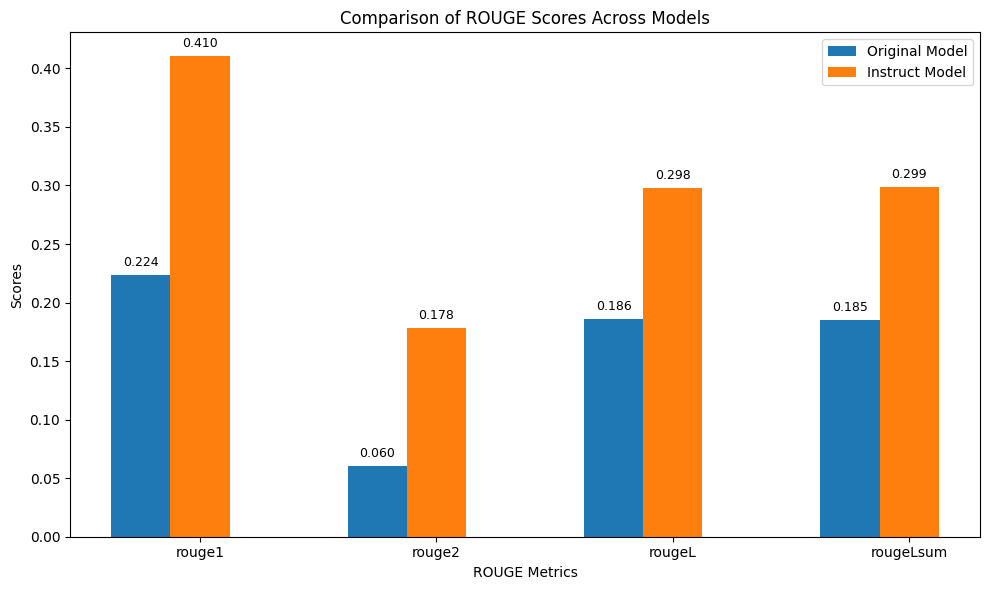

In [70]:
# Use the original variables from the image
results = {
    "Original Model": {
        "rouge1": original_model_results["rouge1"],
        "rouge2": original_model_results["rouge2"],
        "rougeL": original_model_results["rougeL"],
        "rougeLsum": original_model_results["rougeLsum"],
    },
    "Instruct Model": {
        "rouge1": instruct_model_results["rouge1"],
        "rouge2": instruct_model_results["rouge2"],
        "rougeL": instruct_model_results["rougeL"],
        "rougeLsum": instruct_model_results["rougeLsum"],
    }
}

# Extract metrics and models
metrics = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
models = list(results.keys())
data = {metric: [results[model][metric] for model in models] for metric in metrics}

# Plot bar chart
x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

# Add bars for each model
for i, model in enumerate(models):
    bars = ax.bar(x + i * width, [data[metric][i] for metric in metrics], width, label=model)
    
    # Add numbers above each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            height + 0.005,  # Positioning slightly above the bar
            f'{height:.3f}', 
            ha='center', 
            va='bottom', 
            fontsize=9
        )

# Add labels and titles
ax.set_xlabel("ROUGE Metrics")
ax.set_ylabel("Scores")
ax.set_title("Comparison of ROUGE Scores Across Models")
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()

The file `data/dialogue-summary-training-results.csv` contains a pre-populated list of all model results which you can use to evaluate on a larger section of data (output of the above code that was executed on the full dataset). With this, we are able to evaluate the model on the full dataset, without having to inference on each dialogue. 

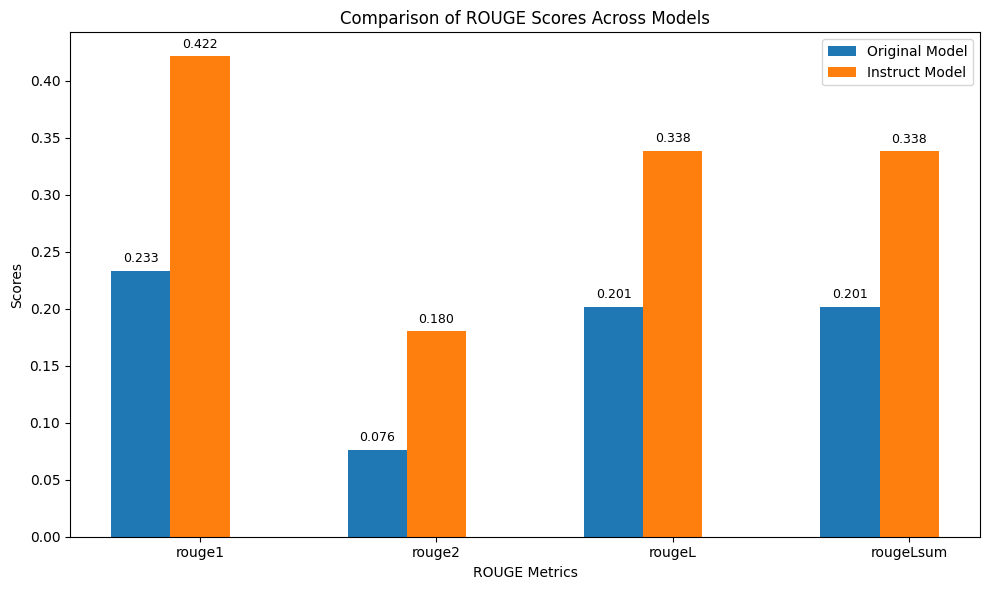

In [80]:
results = pd.read_csv("../data/dialogue-summary-training-results.csv")

human_baseline_summaries = results['human_baseline_summaries'].values
original_model_summaries = results['original_model_summaries'].values
instruct_model_summaries = results['instruct_model_summaries'].values

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

# Use the original variables from the image
results = {
    
    "Original Model": {
        "rouge1": original_model_results["rouge1"],
        "rouge2": original_model_results["rouge2"],
        "rougeL": original_model_results["rougeL"],
        "rougeLsum": original_model_results["rougeLsum"],
    },
    "Instruct Model": {
        "rouge1": instruct_model_results["rouge1"],
        "rouge2": instruct_model_results["rouge2"],
        "rougeL": instruct_model_results["rougeL"],
        "rougeLsum": instruct_model_results["rougeLsum"],
    }
}

# Extract metrics and models
metrics = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
models = list(results.keys())
data = {metric: [results[model][metric] for model in models] for metric in metrics}

# Plot bar chart
x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

# Add bars for each model
for i, model in enumerate(models):
    bars = ax.bar(x + i * width, [data[metric][i] for metric in metrics], width, label=model)
    
    # Add numbers above each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            height + 0.005,  # Positioning slightly above the bar
            f'{height:.3f}', 
            ha='center', 
            va='bottom', 
            fontsize=9
        )

# Add labels and titles
ax.set_xlabel("ROUGE Metrics")
ax.set_ylabel("Scores")
ax.set_title("Comparison of ROUGE Scores Across Models")
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()

The results show substantial improvement in all ROUGE metrics:

In [72]:
print("Absolute percentage improvement of INSTRUCT MODEL over HUMAN BASELINE")

improvement = (np.array(list(instruct_model_results.values())) - np.array(list(original_model_results.values())))
for key, value in zip(instruct_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

Absolute percentage improvement of INSTRUCT MODEL over HUMAN BASELINE
rouge1: 18.82%
rouge2: 10.43%
rougeL: 13.70%
rougeLsum: 13.69%


## 3 - Perform Parameter Efficient Fine-Tuning (PEFT)

This section carries out **Parameter Efficient Fine-Tuning (PEFT)** fine-tuning as opposed to "full fine-tuning" as above. PEFT is a form of instruction fine-tuning that is much more efficient than full fine-tuning - with comparable evaluation results as seen below. 

PEFT is a generic term that includes **Low-Rank Adaptation (LoRA)** and prompt tuning (which is NOT THE SAME as prompt engineering!). Prompt tuning is a technique used to improve the performance of a pre-trained language model without modifying the model’s internal architecture. 

In most cases, when someone says PEFT, they typically mean LoRA. LoRA, at a very high level, allows the user to fine-tune their model using fewer compute resources (in some cases, a single GPU). After fine-tuning for a specific task, use case, or tenant with LoRA, the result is that the original LLM remains unchanged and a newly-trained “LoRA adapter” emerges. This LoRA adapter is much, much smaller than the original LLM - on the order of a single-digit % of the original LLM size (MBs vs GBs). This makes such a big difference, especially when you're constrained by how much compute resources that you have, you can lower the footprint both memory, disk, GPU, CPU, all of the resources can be reduced just by introducing PEFT into the fine-tuning process.

That said, at inference time, the LoRA adapter needs to be reunited and combined with its original LLM to serve the inference request.  The benefit, however, is that many LoRA adapters can re-use the original LLM which reduces overall memory requirements when serving multiple tasks and use cases.


### 3.1 - Setup the PEFT/LoRA model for Fine-Tuning

PEFT/LoRA model needs to be set up for fine-tuning with a new layer/parameter adapter. PEFT/LoRA, freezes the underlying LLM and only trains the adapter. Have a look at the LoRA configuration below. Note the rank (`r`) hyper-parameter, defines the rank/dimension of the adapter to be trained.

A higher rank means a greater number of trainable parameters in the model, making fine-tuning more memory intensive. However, higher ranks retain more information from the original weight matrix, as the decomposed matrices themselves are large and capture most of the essence of the model (i.e., the model becomes more expressive). We can say that, as the rank increases, LORA essentially converges toward normal fine-tuning.

A lower rank means fewer trainable parameters, resulting in less memory required for fine-tuning the model. However, this comes at the expense of the model being less expressive, and not all the information represented by the original weight matrix can be reconstructed through very small ranked A and B matrices.

In [73]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=32, # Rank
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # FLAN-T5
)

Add LoRA adapter layers/parameters to the original LLM to be trained.

In [74]:
peft_model = get_peft_model(original_model, lora_config) # Gets a PEFT version of the model specified in the function
print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 3,538,944
all model parameters: 251,116,800
percentage of trainable model parameters: 1.41%


### 3.2 - Train PEFT Adapter

Define training arguments and create `Trainer` instance.

In [75]:
output_dir = f'./peft-dialogue-summary-training-{str(int(time.time()))}'

peft_training_args = TrainingArguments(
    output_dir=output_dir,
    auto_find_batch_size=True,
    learning_rate=1e-3, # Higher learning rate than full fine-tuning.
    num_train_epochs=1,
    logging_steps=1,
    max_steps=1    
)
    
peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=tokenized_datasets["train"],
)

Now everything is ready to train the PEFT adapter and save the model.


In [76]:
peft_trainer.train()

peft_model_path="./peft-dialogue-summary-checkpoint-local"

peft_trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

100%|██████████| 1/1 [00:48<00:00, 48.63s/it]

{'loss': 48.0, 'grad_norm': 8.701949119567871, 'learning_rate': 0.0, 'epoch': 0.06}
{'train_runtime': 48.6332, 'train_samples_per_second': 0.164, 'train_steps_per_second': 0.021, 'train_loss': 48.0, 'epoch': 0.06}


('./peft-dialogue-summary-checkpoint-local\\tokenizer_config.json',
 './peft-dialogue-summary-checkpoint-local\\special_tokens_map.json',
 './peft-dialogue-summary-checkpoint-local\\tokenizer.json')

That training was performed on a subset of data. To load a fully trained PEFT model, load it from HuggingFace.

When using this model, the original LLM is combined with a LoRA PEFT adapter. These adapters are smaller, reusable, and can be swapped with other PEFT adapters on the same base LLM to handle different use cases.

In [81]:
from peft import PeftModel, PeftConfig

# huggin face alternative
peft_dialogue_summary_checkpoint = 'intotheverse/peft-dialogue-summary-checkpoint'

peft_model_base = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base", torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

peft_model = PeftModel.from_pretrained(peft_model_base,
                                       peft_dialogue_summary_checkpoint, #'./peft-dialogue-summary-checkpoint-from-s3/',
                                       torch_dtype=torch.bfloat16,
                                       is_trainable=False)

c:\Users\rg255041\AppData\Local\anaconda3\envs\PEFT\Lib\site-packages\peft\peft_model.py:372: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  adapters_weights = torch.load(


The number of trainable parameters will be `0` due to `is_trainable=False` setting. This hints to Pytorch that the model is not being used for training, rather for inference only (forward pass only). Pytorch will not load any of the update portion of the operator, minimizing the required compute footprint. 

In [82]:
print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 0
all model parameters: 251,116,800
percentage of trainable model parameters: 0.00%


### 3.3 - Evaluate the Model Qualitatively (Human Evaluation)

Make inferences for the same example as in sections [1.3](#1.3) and [2.3](#2.3), with the original model, fully fine-tuned and PEFT model.

In [83]:
index = 200
dialogue = dataset['test'][index]['dialogue']
baseline_human_summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """

input_ids = tokenizer(prompt, return_tensors="pt").input_ids

original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)

peft_model_outputs = peft_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{human_baseline_summary}')
print(dash_line)
print(f'ORIGINAL MODEL:\n{original_model_text_output}')
print(dash_line)
print(f'INSTRUCT MODEL:\n{instruct_model_text_output}')
print(dash_line)
print(f'PEFT MODEL: {peft_model_text_output}')

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.
---------------------------------------------------------------------------------------------------
ORIGINAL MODEL:
#Person1: I'm thinking of upgrading my computer. #Person2: I'm not sure what I want to do. #Person1: I'd like to have a more powerful processor, more memory, and a faster modem. #Person2: I'd like to have a CD-ROM drive too.
---------------------------------------------------------------------------------------------------
INSTRUCT MODEL:
#Person1# suggests #Person2# upgrading #Person2#'s system, hardware, and CD-ROM drive. #Person2# thinks it's great.
---------------------------------------------------------------------------------------------------
PEFT MODEL: #Person1# recommends adding a painting program to #Person2#'s software and upgrading hardware. #Person2

### 3.4 - Evaluate the Model Quantitatively (with ROUGE Metric)
Perform inferences for the sample of the test dataset (only 10 dialogues and summaries to save time). 

In [84]:
dialogues = dataset['test'][0:10]['dialogue']
human_baseline_summaries = dataset['test'][0:10]['summary']

original_model_summaries = []
instruct_model_summaries = []
peft_model_summaries = []

for idx, dialogue in enumerate(dialogues):
    prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """
    
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids

    human_baseline_text_output = human_baseline_summaries[idx]
    
    original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

    instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)

    peft_model_outputs = peft_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

    original_model_summaries.append(original_model_text_output)
    instruct_model_summaries.append(instruct_model_text_output)
    peft_model_summaries.append(peft_model_text_output)

zipped_summaries = list(zip(human_baseline_summaries, original_model_summaries, instruct_model_summaries, peft_model_summaries))
 
df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'original_model_summaries', 'instruct_model_summaries', 'peft_model_summaries'])
df

,human_baseline_summaries,original_model_summaries,instruct_model_summaries,peft_model_summaries
0,Ms. Dawson helps #Person1# to write a memo to ...,I want to know if you have any questions.,#Person1# asks Ms. Dawson to take a dictation ...,#Person1# asks Ms. Dawson to take a dictation ...
1,In order to prevent employees from wasting tim...,This memo is for employees who are using insta...,#Person1# asks Ms. Dawson to take a dictation ...,#Person1# asks Ms. Dawson to take a dictation ...
2,Ms. Dawson takes a dictation for #Person1# abo...,The memo is intended to be a memo to all emplo...,#Person1# asks Ms. Dawson to take a dictation ...,#Person1# asks Ms. Dawson to take a dictation ...
3,#Person2# arrives late because of traffic jam....,#Person1: I got stuck in traffic. #Person2: I ...,#Person2# got stuck in traffic again. #Person1...,#Person2# got stuck in traffic and #Person1# s...
4,#Person2# decides to follow #Person1#'s sugges...,#Person1: I'm sorry to hear about the traffic ...,#Person2# got stuck in traffic again. #Person1...,#Person2# got stuck in traffic and #Person1# s...
5,#Person2# complains to #Person1# about the tra...,The driver is going to have to stop his car an...,#Person2# got stuck in traffic again. #Person1...,#Person2# got stuck in traffic and #Person1# s...
6,#Person1# tells Kate that Masha and Hero get d...,Masha and Hero are getting divorced.,Masha and Hero are getting divorced. Kate can'...,Kate tells #Person2# Masha and Hero are gettin...
7,#Person1# tells Kate that Masha and Hero are g...,Masha and Hero are getting divorced. Masha and...,Masha and Hero are getting divorced. Kate can'...,Kate tells #Person2# Masha and Hero are gettin...
8,#Person1# and Kate talk about the divorce betw...,Masha and Hero are getting divorced.,Masha and Hero are getting divorced. Kate can'...,Kate tells #Person2# Masha and Hero are gettin...
9,#Person1# and Brian are at the birthday party ...,"#Person1#: Happy birthday, Brian. #Person2#: T...",Brian's birthday is coming. #Person1# invites ...,Brian remembers his birthday and invites #Pers...


Compute ROUGE score for this subset of the data. 

In [85]:
rouge = evaluate.load('rouge')

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

peft_model_results = rouge.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

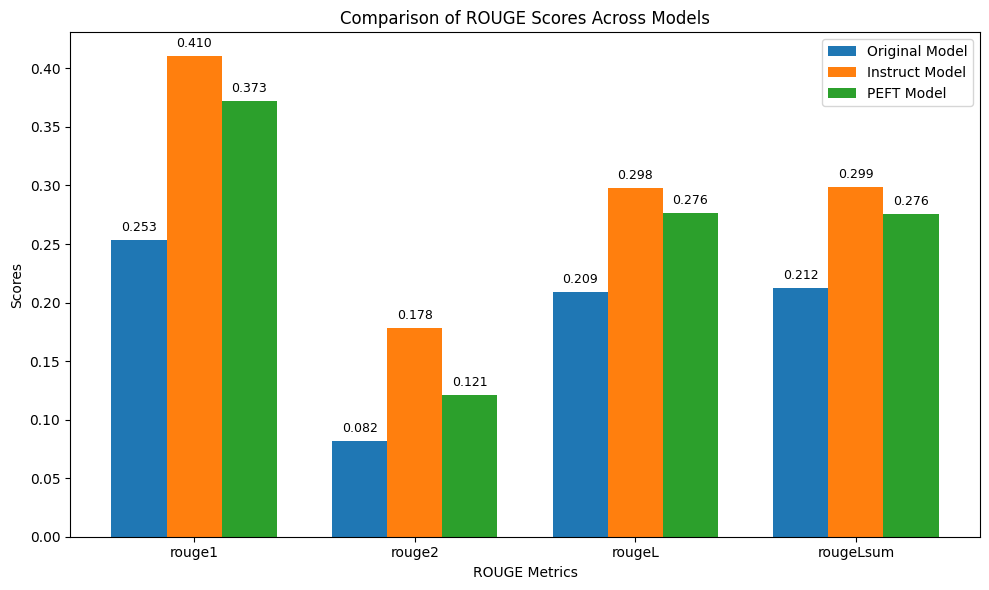

In [86]:
# Use the original variables from the image
results = {
    "Original Model": {
        "rouge1": original_model_results["rouge1"],
        "rouge2": original_model_results["rouge2"],
        "rougeL": original_model_results["rougeL"],
        "rougeLsum": original_model_results["rougeLsum"],
    },
    "Instruct Model": {
        "rouge1": instruct_model_results["rouge1"],
        "rouge2": instruct_model_results["rouge2"],
        "rougeL": instruct_model_results["rougeL"],
        "rougeLsum": instruct_model_results["rougeLsum"],
    },
    "PEFT Model": {
        "rouge1": peft_model_results["rouge1"],
        "rouge2": peft_model_results["rouge2"],
        "rougeL": peft_model_results["rougeL"],
        "rougeLsum": peft_model_results["rougeLsum"],
    },
}

# Extract metrics and models
metrics = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
models = list(results.keys())
data = {metric: [results[model][metric] for model in models] for metric in metrics}

# Plot bar chart
x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

# Add bars for each model
for i, model in enumerate(models):
    bars = ax.bar(x + i * width, [data[metric][i] for metric in metrics], width, label=model)
    
    # Add numbers above each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            height + 0.005,  # Positioning slightly above the bar
            f'{height:.3f}', 
            ha='center', 
            va='bottom', 
            fontsize=9
        )

# Add labels and titles
ax.set_xlabel("ROUGE Metrics")
ax.set_ylabel("Scores")
ax.set_title("Comparison of ROUGE Scores Across Models")
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()

Notice, that PEFT model results are not too bad, while the training process was much easier!

You already computed ROUGE score on the full dataset, after loading the results from the `data/dialogue-summary-training-results.csv` file. Load the values for the PEFT model now and check its performance compared to other models.

In [89]:
results_df = pd.read_csv("../data/dialogue-summary-training-results.csv")

human_baseline_summaries = results_df['human_baseline_summaries'].values
original_model_summaries = results_df['original_model_summaries'].values
instruct_model_summaries = results_df['instruct_model_summaries'].values
peft_model_summaries     = results_df['peft_model_summaries'].values

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

peft_model_results = rouge.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

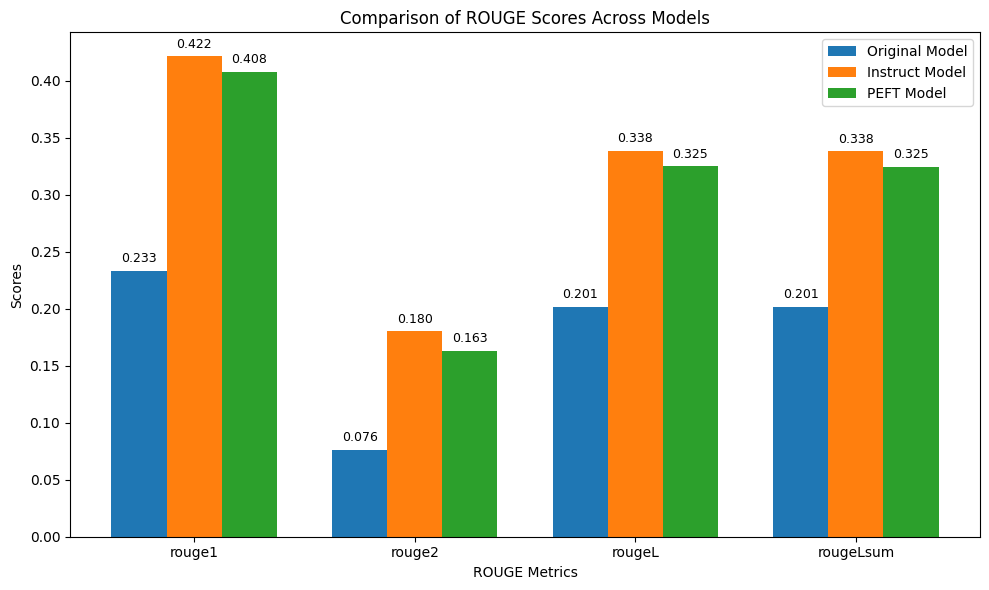

In [90]:
# Use the original variables from the image
results = {
    "Original Model": {
        "rouge1": original_model_results["rouge1"],
        "rouge2": original_model_results["rouge2"],
        "rougeL": original_model_results["rougeL"],
        "rougeLsum": original_model_results["rougeLsum"],
    },
    "Instruct Model": {
        "rouge1": instruct_model_results["rouge1"],
        "rouge2": instruct_model_results["rouge2"],
        "rougeL": instruct_model_results["rougeL"],
        "rougeLsum": instruct_model_results["rougeLsum"],
    },
    "PEFT Model": {
        "rouge1": peft_model_results["rouge1"],
        "rouge2": peft_model_results["rouge2"],
        "rougeL": peft_model_results["rougeL"],
        "rougeLsum": peft_model_results["rougeLsum"],
    },
}

# Extract metrics and models
metrics = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
models = list(results.keys())
data = {metric: [results[model][metric] for model in models] for metric in metrics}

# Plot bar chart
x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

# Add bars for each model
for i, model in enumerate(models):
    bars = ax.bar(x + i * width, [data[metric][i] for metric in metrics], width, label=model)
    
    # Add numbers above each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            height + 0.005,  # Positioning slightly above the bar
            f'{height:.3f}', 
            ha='center', 
            va='bottom', 
            fontsize=9
        )

# Add labels and titles
ax.set_xlabel("ROUGE Metrics")
ax.set_ylabel("Scores")
ax.set_title("Comparison of ROUGE Scores Across Models")
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()

The results show less of an improvement over full fine-tuning, but the benefits of PEFT typically outweigh the slightly-lower performance metrics.

Calculate the improvement of PEFT over the original model:

In [91]:
print("Absolute percentage improvement of PEFT MODEL over HUMAN BASELINE")

improvement = (np.array(list(peft_model_results.values())) - np.array(list(original_model_results.values())))
for key, value in zip(peft_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

Absolute percentage improvement of PEFT MODEL over HUMAN BASELINE
rouge1: 17.47%
rouge2: 8.73%
rougeL: 12.36%
rougeLsum: 12.34%


Now calculate the improvement of PEFT over a full fine-tuned model:

In [92]:
print("Absolute percentage improvement of PEFT MODEL over INSTRUCT MODEL")

improvement = (np.array(list(peft_model_results.values())) - np.array(list(instruct_model_results.values())))
for key, value in zip(peft_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

Absolute percentage improvement of PEFT MODEL over INSTRUCT MODEL
rouge1: -1.35%
rouge2: -1.70%
rougeL: -1.34%
rougeLsum: -1.35%


Here you see a small percentage decrease in the ROUGE metrics vs. full fine-tuned. However, the training requires much less computing and memory resources (often just a single GPU).